## Permanent-transitory income process and income risk estimation
- Author: Tao Wang
- Created Date: Sep, 2022
- Modified Date: Jan, 2025

This notebook includes the code that 
   - simulates cross-sectional realizations
   - simulates and computes population moments
   - estimates income risk parameters using GMM/SMM method
   - that involves time-aggregation, e.g., monthly income progress aggregated into yearly income. 

### Income progress 

\begin{equation}
\begin{split}
& y_{i,t} = \underbrace{p_{i,t}}_{\text{Permanent component}} + \underbrace{\mu_{i,t}}_{\text{Transitory component}}\\& \mu_{i,t} = \underbrace{\underbrace{\theta_{i,t}}_{\text{Transitory shock}} + \phi \theta_{i,t-1}}_{\text{MA(1)}} \\
& p_{i,t} = p_{i,t-1} + \underbrace{\psi_{i,t}}_{\text{Permanent shock}} \\
& \theta_{i,t} \sim N(\frac{-\sigma^2_{\theta}}{2}, \sigma^2_{\theta}) \\
& \psi_{i,t} \sim N(\frac{-\sigma^2_{\psi}}{2}, \sigma^2_{\psi})
\end{split}
\end{equation}

A few things:

- The simulation functionality of the code allows $\phi$ to be non-zero--allowing for the serial correlation of transitory component. But the income risk estimation now only works for the case $\phi=0$: a purely transitory shock, or MA(0).
- The code can handle either constant or time-varying risks, i.e., $\sigma^2_{\psi,t}$ and $\sigma^2_{\theta,t}$
- The code also allows one to specify a stochastic process of $\sigma^2_{\psi,t}$, by making it an AR(1), with the coefficient of $\rho$ and the size of the shock to be $\sigma_\epsilon$. 

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import root 
import copy as cp
import matplotlib.pyplot as plt

## figure plotting configurations


plt.style.use('fivethirtyeight')
plt.rcParams["font.family"] = "Times New Roman" #'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['axes.labelweight'] = 'bold'


In [2]:
## some help functions that are useful in numerical estimations 

def toVec(ma_coeffs,
          sigmas,
          t,
          ma_q):
    assert ma_coeffs.shape == (ma_q,)
    assert sigmas.shape == (2, t)
    return np.hstack([ma_coeffs.flatten(), sigmas.flatten()])

def toPara(vec,
           t,
           ma_q):
    assert len(vec) == 2*t + ma_q
    return vec[:ma_q-1], vec[ma_q:].reshape(2,t)

In [3]:
## A class of integrated moving average process, trend/cycle process allowing for serial correlation of transitory shocks
## This corresponds to the permanent-transitory income process in the literature. 

class IMAProcess:
    '''
    inputs
    ------
    t: int, number of periods of the series
    process_para, a dictionary, includes 
       - ma_coeffs: size of q for MA(q),  moving average coefficients of transitory shocks. q = 0 by default.
         only q =0 or 1 is implemented so far. 
       - sigmas:  size of 2 x t, the sizes of permanent and transitory risks and possibly time-varying 
       In the case of stochastic volatility with constant transitory volatility and path-dependent permanent volatility, following parameters are used as well
       
       - rho: how persistent the innovation to permanent risks is
       - gamma: size of the innovation 
       - sigma_eps: constant transitory volatility 
    '''
    def __init__(self,
                 t = 100,                   ## length of sample period  
                 #n_periods = np.array([1]), ## # of periods for time aggregation 
                 ma_coeffs = np.ones(1),    
                 #sigmas = np.ones([2,100]),
                ):
        #self.process_para = process_para
        self.ma_coeffs = ma_coeffs
        self.ma_q = self.ma_coeffs.shape[0]
        self.t = t
        self.sigmas =  np.ones([2,t])
        self.n_agg = 12
        self.init_sigmas = np.array([0.1,0.1])
        self.init_sv = np.array([0.1,0.1])
        
        ## stochastic vol paras
        
        self.rho = 0.5
        self.gamma = 0.001
        self.sigma_eps = 0.1/12
        
    ## auxiliary function for ma cum sum
    def cumshocks(self,
                  shocks,
                  ma_coeffs):
        cum = []
        for i in range(len(shocks)):
            #print(shocks[i])
            #print(sum([ma_coeffs[back]*shocks[i-back] for back in range(len(ma_coeffs))]))
            cum.append(sum([ma_coeffs[back]*shocks[i-back] for back in range(len(ma_coeffs))]))
        return np.array(cum)         


##########
## new ###
##########
        
    def SimulateSeries(self,
                       n_sim = 200):
        t = self.t 
        ma_coeffs = self.ma_coeffs
        sigmas = self.sigmas
        np.random.seed(12345)                 
        p_draws = np.multiply(np.random.randn(n_sim*t).reshape([n_sim,t]), 
                              np.tile(sigmas[0,:],[n_sim,1]))  # draw permanent shocks
        np.random.seed(12342)
        t_draws = np.multiply(np.random.randn(n_sim*t).reshape([n_sim,t]), 
                              np.tile(sigmas[1,:],[n_sim,1]))  ## draw one-period transitory shocks
    
        t_draws_cum = np.array( [self.cumshocks(shocks = t_draws[i,:],
                                                ma_coeffs = ma_coeffs) 
                                 for i in range(n_sim)]
                              )
        series = np.cumsum(p_draws,axis = 1) + t_draws_cum 
        self.simulated = series
        return self.simulated 
       
    def SimulatedMoments(self):
        series = self.simulated 
        
        ## the first difference 
        diff = np.diff(series,axis=1)
        
        ## moments of first diff
        mean_diff = np.mean(diff,axis = 0)
        varcov_diff = np.cov(diff.T)
        
        self.SimMoms = {'Mean':mean_diff,
                       'Var':varcov_diff}
        return self.SimMoms
    
    def TimeAggregate(self):
        n_agg = self.n_agg
        simulated = self.simulated
        t = self.t
        simulated_agg = np.array([np.sum(simulated[:,i-n_agg:i],axis=1) for i in range(n_agg,t+1)]).T
        self.simulated_agg = simulated_agg
        return self.simulated_agg
    
    def SimulateMomentsAgg(self):
        series_agg = self.simulated_agg 
        
        ## the first difference 
        diff = np.diff(series_agg,
                       axis = 1)
        ## moments of first diff
        mean_diff = np.mean(diff,axis = 0)
        varcov_diff = np.cov(diff.T)
        
        self.SimAggMoms = {'Mean':mean_diff,
                           'Var':varcov_diff}
        return self.SimAggMoms

    
    def ComputeMomentsAgg(self):
        n_agg = self.n_agg
        sigmas = self.sigmas
        sigmas_theta = sigmas[0,:]
        sigmas_eps = sigmas[1,:]
        
        n = n_agg 
        t = self.t 
        
        t_truc = t - 2*n 
        
        ## prepare the locations for var-cov matrix 
        var_cov = np.zeros([t,t])
        
        ## prepare a (2n-1) x 1  vector [1,2...n,n-1..1]
        M_vec0 = np.arange(n-1)+1
        M_vec1 = np.flip(np.arange(n)+1)  
        M_vec =  np.concatenate((M_vec0,M_vec1))
        
        ## prepare a 2n x 1 vector [-1,-1...,1,1]
        I_vec0 = - np.ones(n)
        I_vec1 = np.ones(n)
        I_vec =  np.concatenate((I_vec0,I_vec1))
        
        for i in np.arange(t_truc)+n:
            for k in np.arange(n)+1:   ## !!!need to check here. 
                var_cov[i,i+k] = ( sum(M_vec[k:]*M_vec[:-k]*sigmas_theta[i+1-n:i+n-k]**2)
                                  + sum(I_vec[k:]*I_vec[:-k]*sigmas_eps[i-n:i+n-k]**2) ) # need to check 
                var_cov[i+k,i] = var_cov[i,i+k]
            var_cov[i,i] = sum(M_vec**2*sigmas_theta[i+1-n:i+n]**2)
        
        self.Moments_Agg = var_cov
        return self.Moments_Agg
    
    def ComputeGenMoments(self):
        ## parameters 
        t = self.t 
        sigmas = self.sigmas
        p_sigmas = sigmas[0,:]
        t_sigmas = sigmas[1,:]
        
        ## generalized moments 
        mean_diff = np.zeros(t)[1:] 
        ## varcov is basically the variance covariance of first difference of income of this IMA(q) process
        ## Cov(delta y_t - delta y_{t+k}) forall k for all t
        varcov_diff =  np.asmatrix( np.zeros((t)**2).reshape([t,t]) )
        
        for i in range(t):
            autocovf_this = p_sigmas[i]**2 + t_sigmas[i]**2 + t_sigmas[i-1]**2
            varcov_diff[i,i] = autocovf_this
            try:
                varcov_diff[i,i+1] = - t_sigmas[i]**2
                varcov_diff[i+1,i] = - t_sigmas[i]**2            
            except:
                pass
        varcov_diff = varcov_diff[1:,1:]
        self.GenMoms = {'Mean':mean_diff,
                       'Var':varcov_diff}
        return self.GenMoms
    
    def GetDataMoments(self,
                      data_moms_dct):
        self.data_moms_dct = data_moms_dct
        
    def GetDataMomentsAgg(self,
                          data_moms_agg_dct):
        self.data_moms_agg_dct = data_moms_agg_dct    

        
    def ObjFunc(self,
                para):
        data_moms_dct = self.data_moms_dct
        t = self.t
        ma_q = self.ma_q
        ma_coeffs,sigmas = toPara(para,
                                  t,
                                  ma_q)
        self.ma_coeffs = ma_coeffs
        self.sigmas = sigmas
        model_moms_dct = self.ComputeGenMoments() 
        model_moms = np.array([model_moms_dct[key] for key in ['Var']]).flatten()
        data_moms = np.array([data_moms_dct[key] for key in ['Var']]).flatten()
        diff = np.linalg.norm(model_moms - data_moms)
        return diff
    
    def EstimatePara(self,
                     method = 'CG',
                     bounds = None,
                     para_guess = None,
                     options = {'disp':True}):
        t = self.t
        ma_q = self.ma_q
        
        para_est = minimize(self.ObjFunc,
                            x0 = para_guess,
                            method = method,
                            bounds = bounds,
                            options = options)['x']
        
        self.para_est = toPara(para_est,
                               t,
                               ma_q)
        
        return self.para_est    
    
    def EstimateParaRoot(self,
                         para_guess = None):
        t = self.t
        ma_q = self.ma_q
        
        para_est = root(self.ObjFunc,
                       x0 = para_guess)['x']
        
        self.para_est = toPara(para_est,
                               t,
                               ma_q)
        
        return self.para_est 
    
    def ObjFuncSim(self,
                   para_sim):
        data_moms_dct = self.data_moms_dct
        t = self.t
        ma_q = self.ma_q
        ma_coeffs,sigmas = toPara(para_sim,
                                  t,
                                  ma_q)
        self.ma_coeffs = ma_coeffs
        self.sigmas = sigmas
        model_moms_dct = self.SimulatedMoments()  
        model_moms = np.array([model_moms_dct[key] for key in ['Var']]).flatten()
        data_moms = np.array([data_moms_dct[key] for key in ['Var']]).flatten()
        diff = np.linalg.norm(model_moms - data_moms)
        return diff
        
    def EstimateParabySim(self,
                          method = 'CG',
                          bounds = None,
                          para_guess = None,
                          options = {'disp':True}):
        t = self.t
        ma_q = self.ma_q
        
        para_est_sim = minimize(self.ObjFuncSim,
                                x0 = para_guess,
                                method = method,
                                bounds = bounds,
                                options = options)['x']
        
        self.para_est_sim = toPara(para_est_sim,
                                   t,
                                   ma_q)
        
        return self.para_est_sim    
    
    def ObjFuncAgg(self,
                   para_agg):
        data_moms_agg_dct = self.data_moms_agg_dct
        t = self.t
        ma_q = self.ma_q
        n_periods = self.n_periods
        ma_coeffs,sigmas = toPara(para_agg,
                                  t,
                                  ma_q)
        new_instance = cp.deepcopy(self)
        new_instance.t = t   
        new_instance.ma_coeffs = ma_coeffs
        new_instance.sigmas = sigmas
        model_series_sim = new_instance.SimulateSeries() 
        model_series_agg = new_instance.TimeAggregate(n_periods = n_periods)
        model_moms_agg_dct = new_instance.SimulateMomentsAgg()
        
        model_moms = np.array([model_moms_agg_dct[key] for key in ['Var']]).flatten()
        data_moms = np.array([data_moms_agg_dct[key] for key in ['Var']]).flatten()
        if len(model_moms) > len(data_moms):
            n_burn = len(model_moms) - len(data_moms)
            model_moms = model_moms[n_burn:]
        if len(model_moms) < len(data_moms):
            n_burn = -(len(model_moms) - len(data_moms))
            data_moms = data_moms[n_burn:]
        diff = np.linalg.norm(model_moms - data_moms)
        return diff
    
    def EstimateParaAgg(self,
                        method = 'CG',
                        bounds = None,
                        para_guess = None,
                        options = {'disp':True}):
        t = self.t
        ma_q = self.ma_q
        para_est_agg = minimize(self.ObjFuncAgg,
                                x0 = para_guess,
                                method = method,
                                bounds = bounds,
                                options = options)['x']
        
        self.para_est_agg = toPara(para_est_agg,
                                   t,
                                   ma_q)
        return self.para_est_agg  
    
    def ObjFuncAggCompute(self,
                          para_agg):
        data_moms_agg_dct = self.data_moms_agg_dct
        t = self.t
        ma_q = self.ma_q
        ma_coeffs,sigmas = toPara(para_agg,
                                  t,
                                  ma_q)
        new_instance = cp.deepcopy(self)
        new_instance.t = t   
        new_instance.ma_coeffs = ma_coeffs
        new_instance.sigmas = sigmas
        #model_series_sim = new_instance.SimulateSeries() 
        #model_series_agg = new_instance.TimeAggregate(n_periods = n_periods)
        model_moms_agg_dct = new_instance.ComputeMomentsAgg()
        
        model_moms = np.array([model_moms_agg_dct[key] for key in ['Var']]).flatten()
        data_moms = np.array([data_moms_agg_dct[key] for key in ['Var']]).flatten()
        if len(model_moms) > len(data_moms):
            n_burn = len(model_moms) - len(data_moms)
            model_moms = model_moms[n_burn:]
        if len(model_moms) < len(data_moms):
            n_burn = -(len(model_moms) - len(data_moms))
            data_moms = data_moms[n_burn:]
        diff = np.linalg.norm(model_moms - data_moms)
        return diff
    
    def EstimateParaAggCompute(self,
                               method = 'Nelder-Mead',
                               bounds = None,
                               para_guess = None,
                               options = {'disp':True}):
        t = self.t
        ma_q = self.ma_q
        para_est_agg = minimize(self.ObjFuncAggCompute,
                                x0 = para_guess,
                                method = method,
                                bounds = bounds,
                                options = options)['x']
        
        self.para_est_agg_compute = toPara(para_est_agg,
                                           t,
                                           ma_q)
        return self.para_est_agg_compute  
    
    def Autocovar(self,
                  step = 1):
        cov_var = self.SimMoms['Var']
        if step >= 0:
            autovar = np.array([cov_var[i,i+step] for i in range(len(cov_var)-1)])
        if step < 0:
            autovar = np.array([cov_var[i+step,i] for i in range(abs(step),len(cov_var)-1)]) 
        self.autovar = autovar
        return self.autovar
    
    def AutocovarComp(self,
                  step = 1):
        cov_var = self.GenMoms['Var']
        if step >= 0:
            autovar = np.array([cov_var[i,i+step] for i in range(len(cov_var)-1)])
        if step < 0:
            autovar = np.array([cov_var[i+step,i] for i in range(abs(step),len(cov_var)-1)]) 
        self.autovarGen = autovar
        return self.autovarGen
    
    def AutocovarAgg(self,
                     step = 0):
        cov_var = self.SimAggMoms['Var']
        if step >=0:
            autovar = np.array([cov_var[i,i+step] for i in range(len(cov_var)-1)]) 
        if step < 0:
            autovar = np.array([cov_var[i,i+step] for i in range(abs(step),len(cov_var)-1)]) 
        self.autovar = autovar
        self.autovaragg = autovar

        return self.autovaragg 
    
    
###################
#### stochastic vols 
###################

    
    ## simulated cross sectional vols before time aggregation, i.e. monthly 
    
    def SimulateSVols(self,
                      n_sim = 200):
        rho = self.rho
        gamma = self.gamma
        sigma_eps = self.sigma_eps
        t = self.t
        t_burn = int(0.1*t)
        t_long = t + t_burn 
        init_sigmas = self.init_sigmas        
        sigmas_eps = sigma_eps*np.ones([n_sim,t_long])
        sigmas_theta = np.empty([n_sim,t_long])
        sigmas_theta[:,0] = 0.001
        
        np.random.seed(1235)
        mu_draws = gamma*np.random.randn(n_sim*t_long).reshape([n_sim,t_long]) 
        
        for i in range(n_sim):
            for j in range(t_long-1):
                sigmas_theta[i,j+1] = np.sqrt(np.exp(rho*np.log(sigmas_theta[i,j]**2) + mu_draws[i,j+1]))
        
        self.sigmas_theta_sim = sigmas_theta[:,t_burn:]
        self.sigmas_eps_sim = sigmas_eps[:,t_burn:]
        self.vols_sim = sigmas_theta**2 + sigmas_eps**2
    
        return self.vols_sim 
    
    ## time aggregated cross sectional vols
    
    def SimulateSVolsAgg(self):
        n_agg = self.n_agg 
        # get the simulate monthly volatility 
        sigmas_theta_sim = self.sigmas_theta_sim
        sigmas_eps_sim =  self.sigmas_eps_sim
        
        ## create locations for yearly volatility 
        nsim, t = sigmas_theta_sim.shape
        vols_sim_agg = np.empty_like(sigmas_theta_sim)
        
        
        ## fill the volatility  
        for i in range (nsim):
            for j in range(t):
                vols_theta_this = sum([(n_agg-k-1)**2*self.hstep_sigma_theta(sigmas_theta_sim[i,j],k) for k in range(n_agg)])
                vols_eps_this = n_agg**2*sigmas_eps_sim[i,j]**2
                vols_sim_agg[i,j] = vols_theta_this + vols_eps_this
                
        self.vols_sim_agg = vols_sim_agg
        return self.vols_sim_agg
    
    ## moms of time aggregated vols
                        
    def SimulateSVolsAggMoms(self):
        vols_sim_agg = self.vols_sim_agg
        vols_agg_av = np.mean(vols_sim_agg)
        vols_agg_cov = np.cov(vols_sim_agg.T)
        vols_agg_atv = np.empty(self.n_agg)
        
        for k in range(self.n_agg):
            vols_agg_atv[k] = np.mean([vols_agg_cov[i,i+k] for i in range(self.t) if i< (self.t-k)])
        
        self.vols_agg_sim_moms = {'Mean':vols_agg_av,
                                  'Var':vols_agg_cov,
                                 'ATV':vols_agg_atv}
        return self.vols_agg_sim_moms 
    
    def GetDataMomentsVolsAgg(self,
                              data_vols_moms_agg_dct):
        self.data_vols_moms_agg_dct = data_vols_moms_agg_dct 

    def ObjFuncAggVols(self,
                       para_vols_agg):
        
        self.rho,self.gamma,self.sigma_eps = para_vols_agg
        
        ## data agg vols
        data_vols_moms_agg_dct = self.data_vols_moms_agg_dct
        
        new_instance = cp.deepcopy(self)
        new_instance.SimulateSVols()
        new_instance.SimulateSVolsAgg()
        model_vols_moms_agg_dct = new_instance.SimulateSVolsAggMoms()
        #print(model_vols_moms_agg_dct)
        
        ## criteria 
        model_moms = np.array([model_vols_moms_agg_dct[key] for key in ['ATV']]).flatten()
        model_moms = np.hstack([model_moms, model_vols_moms_agg_dct['Mean']])
        data_moms = np.array([data_vols_moms_agg_dct[key] for key in ['ATV']]).flatten()
        data_moms = np.hstack([data_moms, data_vols_moms_agg_dct['Mean']])
        
        if len(model_moms) > len(data_moms):
            n_burn = len(model_moms) - len(data_moms)
            model_moms = model_moms[n_burn:]
        if len(model_moms) < len(data_moms):
            n_burn = -(len(model_moms) - len(data_moms))
            data_moms = data_moms[n_burn:]
        diff = np.linalg.norm(model_moms - data_moms)
        return diff
    
    def EstimateSVolsParaAgg(self,
                             method = 'Nelder-Mead',
                             bounds = None,
                             para_guess = (0.7,0.01,0.01),
                             options = {'disp':True}):
        self.para_svols_est_agg = minimize(self.ObjFuncAggVols,
                                           x0 = para_guess,
                                           method = method,
                                           bounds = bounds,
                                           options = options)['x']

        return self.para_svols_est_agg 


#################
## other funcs
##################
    def hstep_sigma_theta(self,
                          sigma_theta_now,
                          k):
        k_step_sigma_theta = self.rho**k*np.exp(-0.5*self.gamma)*(sigma_theta_now**2)
        return k_step_sigma_theta

In [4]:
if __name__ == "__main__":
    
    ## Simulate series using some fake parameters. 

    t = 100
    ma_nosa = np.array([1])  ## ma coefficient without serial correlation
    p_sigmas = np.random.uniform(0,1,t) ## allowing for time-variant shocks 
    pt_ratio = 0.33
    t_sigmas = pt_ratio * p_sigmas # sizes of the time-varying permanent volatility
    sigmas = np.array([p_sigmas,
                       t_sigmas])

    dt = IMAProcess(t = t,
             ma_coeffs = ma_nosa)
    dt.sigmas = sigmas
    sim_data = dt.SimulateSeries(n_sim = 2000)
    sim_moms = dt.SimulatedMoments()

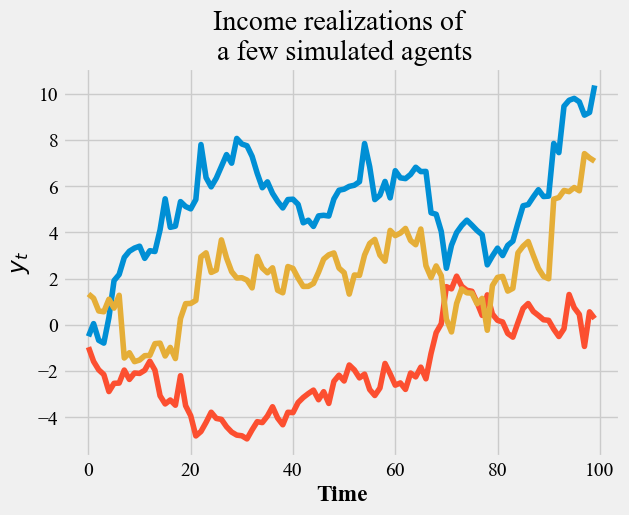

In [5]:
if __name__ == "__main__":
    
    ## plot the simulated data for 10 individuals 
    
    plt.plot(sim_data[0,:])
    plt.plot(sim_data[1,:])
    plt.plot(sim_data[3,:])
    plt.xlabel('Time')
    plt.ylabel(r'$y_t$')
    plt.title('Income realizations of \n a few simulated agents')

In [6]:
if __name__ == "__main__":
    ## get the computed moments 

    comp_moms = dt.ComputeGenMoments()
    av_comp = comp_moms['Mean']
    cov_var_comp = comp_moms['Var']
    var_comp = dt.AutocovarComp(step=0) #np.diagonal(cov_var_comp)
    autovarb1_comp = dt.AutocovarComp(step=-1)  #np.array([cov_var_comp[i,i+1] for i in range(len(cov_var_comp)-1)]) 
    
    
    ## get the simulated moments 
    sim_moms = dt.SimulatedMoments()
    av = sim_moms['Mean']
    cov_var = sim_moms['Var']
    var = dt.Autocovar(step = 0)   #= np.diagonal(cov_var)
    autovarb1 = dt.Autocovar(step = -1) #np.array([cov_var[i,i+1] for i in range(len(cov_var)-1)]) 

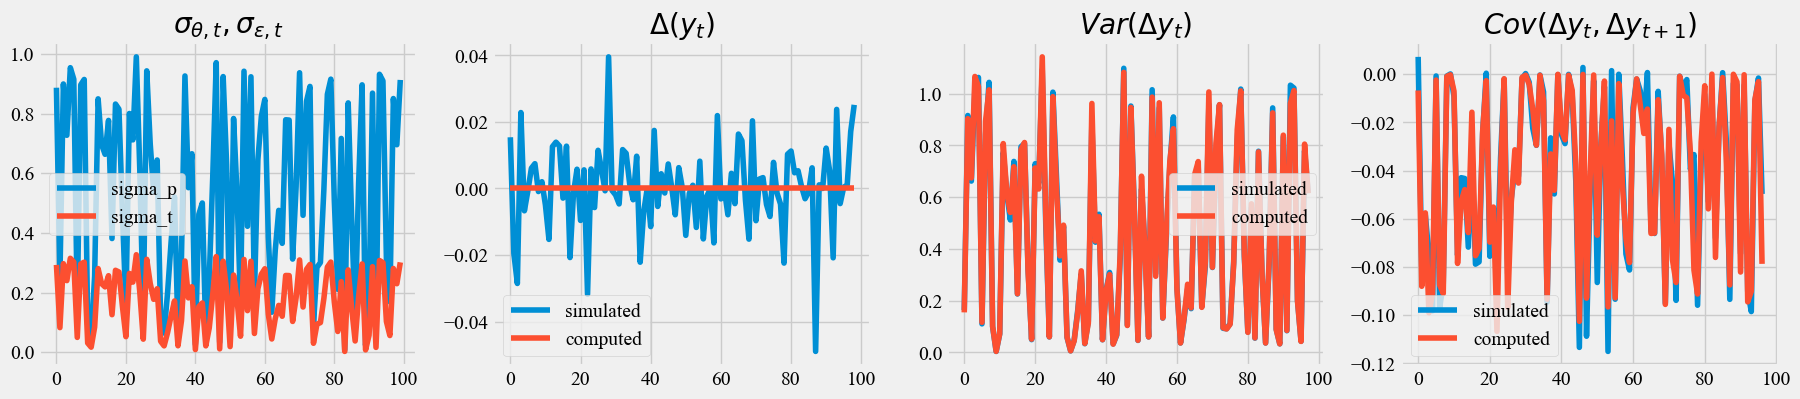

In [7]:
if __name__ == "__main__":

    ## plot simulated moments of first diff 

    plt.figure(figsize=(20,4))

    plt.subplot(1,4,1)
    plt.title(r'$\sigma_{\theta,t},\sigma_{\epsilon,t}$')
    plt.plot(p_sigmas,label='sigma_p')
    plt.plot(t_sigmas,label='sigma_t')
    plt.legend(loc=0)

    plt.subplot(1,4,2)
    plt.title(r'$\Delta(y_t)$')
    plt.plot(av,label='simulated')
    plt.plot(av_comp,label='computed')
    plt.legend(loc=0)

    plt.subplot(1,4,3)
    plt.title(r'$Var(\Delta y_t)$')
    plt.plot(var,label='simulated')
    plt.plot(var_comp,label='computed')
    plt.legend(loc=0)

    plt.subplot(1,4,4)
    plt.title(r'$Cov(\Delta y_t,\Delta y_{t+1})$')
    plt.plot(autovarb1,label='simulated')
    plt.plot(autovarb1_comp,label='computed')
    plt.legend(loc = 0)

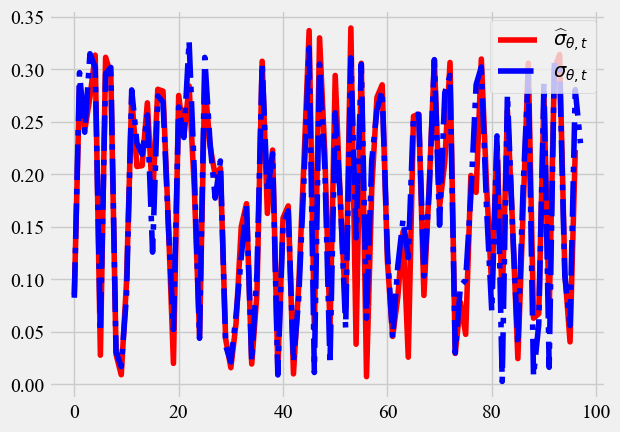

In [8]:
if __name__ == "__main__":

    ## Since transitory risk is equal to autocovariance of first-difference,
    ## we can easily check if the estimated transitory risks are equal to the assigned level.

    sigma_t_est = np.array(np.sqrt(abs(autovarb1)))
    plt.plot(sigma_t_est,'r-',label=r'$\widehat \sigma_{\theta,t}$')
    plt.plot(t_sigmas[1:-1],'b-.',label=r'$\sigma_{\theta,t}$')  # the head and tail trimmed
    plt.legend(loc=1)

### Estimating income risks using fake data 

In [9]:
if __name__ == "__main__":
    
    
    ## some fake data moments with alternative parameters
    
    ## both p and t risks are draws
    p_sigmas_draw = np.random.uniform(0,1,t)
    t_sigmas_draw = np.random.uniform(0,1,t)

    sigmas_fake = np.array([p_sigmas_draw,
                       t_sigmas_draw])

    dt_fake = IMAProcess(t = t,
                  ma_coeffs = ma_nosa)
    dt_fake.sigmas = sigmas_fake
    data_fake = dt_fake.SimulateSeries(n_sim = 2000)
    moms_fake = dt_fake.SimulatedMoments()

In [10]:
if __name__ == "__main__":

    ## estimation of income risks 

    dt_est = cp.deepcopy(dt)
    dt_est.GetDataMoments(moms_fake)

    para_guess_this = np.ones(2*t  + dt_est.ma_q)  # make sure the length of the parameters are right 

    para_est = dt_est.EstimatePara(method='BFGS',
                                   para_guess = para_guess_this)

Optimization terminated successfully.
         Current function value: 2.304450
         Iterations: 155
         Function evaluations: 32926
         Gradient evaluations: 163


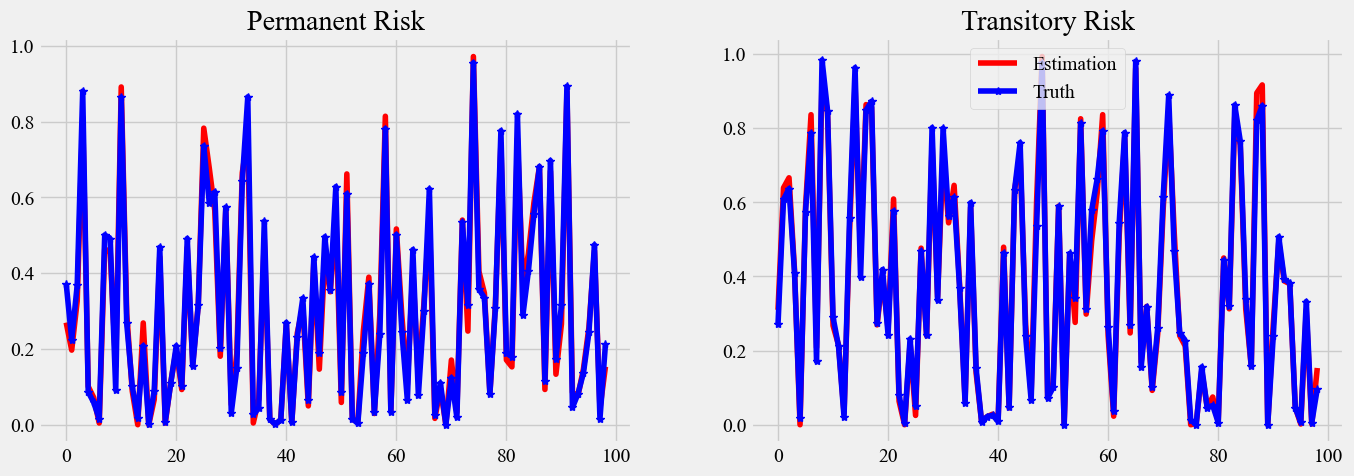

In [11]:
if __name__ == "__main__":

    ## check the estimation and true parameters 

    fig = plt.figure(figsize=([15,5]))

    plt.subplot(1,2,1)
    plt.title('Permanent Risk')
    plt.plot(dt_est.para_est[1][0][1:].T**2,'r-',label='Estimation')
    plt.plot(dt_fake.sigmas[0][1:]**2,'b-*',label='Truth')

    plt.subplot(1,2,2)
    plt.title('Transitory Risk')
    plt.plot(dt_est.para_est[1][1][1:].T**2,'r-',label='Estimation')
    plt.plot(dt_fake.sigmas[1][1:]**2,'b-*',label='Truth')
    plt.legend(loc=0)